In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt

## Знакомство с данными

In [2]:
df = pd.read_csv("ds_problem/problem_train.csv")
df.head()

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN


In [3]:
df_target = pd.read_csv('ds_problem/problem_labels.csv')
df_target.head()

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,11382,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,16531,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1896,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,18262,0,0,0,1,1,0,0,0,0,0,1,1,1,0


In [4]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_target.drop('id', axis=1), 20))

Top Absolute Correlations
service_l  service_m    0.804081
service_a  service_b    0.557859
service_j  service_k    0.533591
service_d  service_e    0.418327
service_b  service_c    0.405167
service_f  service_g    0.395226
service_a  service_c    0.330330
service_h  service_l    0.308826
service_c  service_g    0.267283
service_h  service_m    0.213137
service_c  service_e    0.182957
service_h  service_n    0.178128
service_d  service_m    0.173341
service_e  service_m    0.172998
service_h  service_i    0.170898
service_e  service_l    0.166700
service_d  service_l    0.150511
service_c  service_m    0.137605
service_b  service_g    0.135366
service_c  service_h    0.134676
dtype: float64


In [5]:
#Посмотрим на балансы классов
for col in df_target.drop('id', axis=1).columns:
    print(col, df_target[col].mean())

service_a 0.472125
service_b 0.32825
service_c 0.261625
service_d 0.017
service_e 0.053875
service_f 0.029125
service_g 0.051875
service_h 0.297
service_i 0.016125
service_j 0.84825
service_k 0.782
service_l 0.108
service_m 0.088625
service_n 0.178


In [86]:
#посмотрим на категориальные фичи
cat_features = [col for col in df.columns if df[col].dtype == np.object]
for col in df.drop('id', axis=1).columns:
    if col not in cat_features and df[col].fillna(-1).\
                apply(lambda x: int(x) == x or int(x * 10) == x * 10).sum() == df.shape[0]:
        cat_features.append(col)
len(cat_features)

1285

## обработка пустых значений

Разделим выборку на треин и тест. Обучим бейзлайновую модель с заполнением пропусков константой  

In [9]:
def fitiing_base_model(df, df_target, cat_features=[]):
    for col in df_target.drop('id', axis=1).columns:
        df_train, df_test = train_test_split(
            df,
            test_size=0.25,
            stratify=df_target[col]
        )
        model = CatBoostClassifier(iterations=50, cat_features=cat_features)
        train = df_train.merge(df_target[['id', col]], on='id', how='inner')
        X, y = train.drop([col, 'id'], axis=1), train[col]
        model.fit(X, y, verbose=False)
        scores_train.append(log_loss(y, model.predict_proba(X)[:, 1]))
        test = df_test.merge(df_target[['id', col]], on='id', how='inner')
        X, y = test.drop([col, 'id'], axis=1), test[col]
        scores_test.append(log_loss(y, model.predict_proba(X)[:, 1]))
    return (np.mean(scores_train), np.mean(scores_test))

In [48]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss

scores_train = []
scores_test = []
df_const = df.fillna(-1)

train_score, test_score = fitiing_base_model(df_const, df_target, cat_features)

In [49]:
print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Среднее качество на треине 0.2085793740695717
Среднее качество на тесте 0.26844190615770963


Проведем эксперименты с колонками, у которых разреженность не более 0.95

In [97]:
df_clear = df.copy()
for col in df.columns:
    if df_clear[col].isna().sum() / df_clear.shape[0] >= 0.95:
        df_clear = df_clear.drop(col, axis=1)
        if col in cat_features:
            cat_features.remove(col)
df_clear.shape

(8000, 609)

In [55]:
for col in cat_features:
    if df_clear[col].value_counts().shape[0] < 2:
        print(col)

In [57]:
df['c_1078'].value_counts()

b    1489
Name: c_1078, dtype: int64

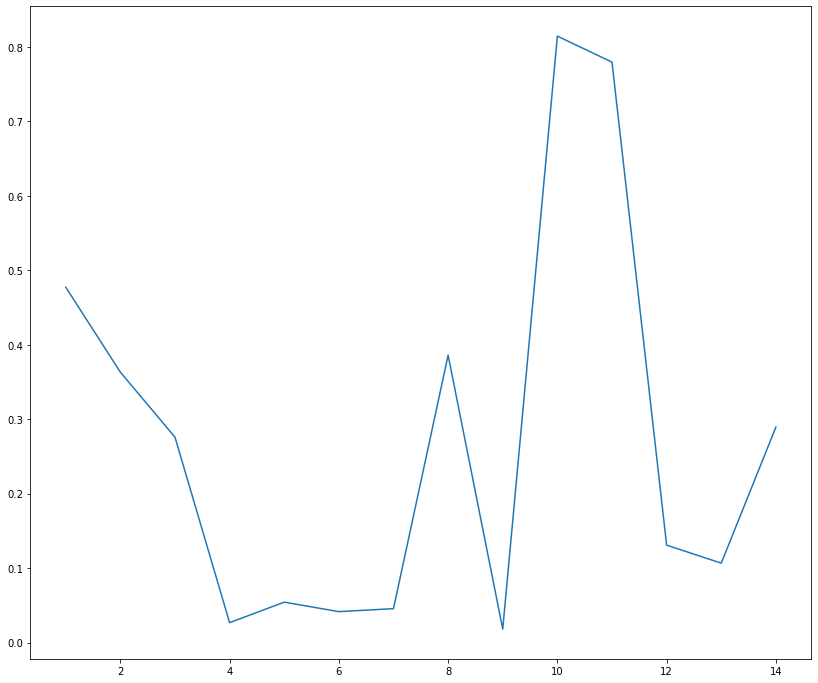

In [65]:
fig = plt.figure()
fig.set_size_inches(14, 12)

mean = df[df['c_1078'] == 'b'][['id', 'c_1078']].merge(df_target, on='id', how='inner').drop('id', axis=1).mean()

plt.plot(range(1, 15), mean)

In [98]:
#В целом фича дает сильно разные конверсии, поэтому не будем ее удалять, а обработаем
df_clear['c_1078'] = df_clear['c_1078'].map({'b' : 1}).fillna(0)

In [96]:
#!pip install category_encoders
import category_encoders as ce
from sklearn.decomposition import PCA


def target_encode(df, col, y):
    class_names=y.columns
    
    clasters = pd.DataFrame()
    for class_ in class_names:
        temp = pd.DataFrame()
        mean = df.merge(y, on='id', how='inner').groupby(col)[class_].mean()
        temp[col + class_] = df[col].map(mean)
        clasters = pd.concat([clasters, temp], axis=1)
    clasters = clasters.to_numpy()
    pca = PCA(n_components=4)
    pca_decomp = pd.DataFrame(pca.fit_transform(clasters), columns = [col + str(i) for i in range(4)])
    df = df.drop(col, axis=1)
    df=pd.concat([df, pca_decomp], axis=1)    

    return df

Будем обрабатывать категориальные значения по следующему правилу: если не более 4 уникальных значений, то буду делать заполнение пропусков модой и затем One-Hot-Encoding, иначе буду обрабатывать Target-Encoding с заполнением пропусков модой. Здесь можно провести очень много разных экспериментов. Но попытаемся по логике принять на веру, что это лучший вариант

In [99]:
for col in cat_features:
    if df_clear[col].value_counts().shape[0] <= 4:
        df_clear[col] = df_clear[col].fillna(df_clear[col].value_counts().index[0])
        one_hot = pd.get_dummies(df_clear[col], prefix=col, drop_first=True)
        df_clear = pd.concat((df_clear.drop(col, axis=1), one_hot), axis=1)
    else:
        df_clear[col] = df_clear[col].fillna(df_clear[col].value_counts().index[0])
        if df_clear[col].dtype != np.object:
            df_clear[col] = df_clear[col].astype(np.int64)
        df_clear = target_encode(df_clear, col, df_target)
        

In [100]:
df_clear.head()

,id,n_0002,n_0005,n_0007,n_0012,n_0015,n_0017,n_0020,n_0025,n_0027,...,o_03193,o_0323_1.0,o_0323_2.0,o_0323_3.0,o_0324_1.0,o_0324_2.0,o_03260,o_03261,o_03262,o_03263
0,11193,0.025449,0.368421,NaN,0.292683,NaN,NaN,NaN,NaN,NaN,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974
1,11382,0.031297,0.315789,NaN,0.243902,NaN,NaN,NaN,NaN,NaN,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974
2,16531,0.024475,0.342105,NaN,0.304878,NaN,NaN,NaN,NaN,NaN,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974
3,1896,0.041694,0.447368,NaN,0.207317,NaN,NaN,NaN,NaN,NaN,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974
4,18262,0.038120,0.315789,NaN,0.219512,NaN,0.388889,NaN,0.0,NaN,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974


In [101]:
#Отправим на самостоятельное заполнение пропусков catboost 
train_score, test_score = fitiing_base_model(df_clear, df_target)

print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Среднее качество на треине 0.19086954307004128
Среднее качество на тесте 0.2770362816774254


Заполнение пропусков средним значением

In [103]:
df_med = df_clear.copy()
for col in df_med.drop('id', axis=1).columns:
    df_med[col] = df_med[col].fillna(df_med[col].mean())
    
train_score, test_score = fitiing_base_model(df_med, df_target)

In [22]:
print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Среднее качество на треине 0.19143225158322896
Среднее качество на тесте 0.2803081832180803


Заполнение при помощи линейной регрессии

In [88]:
from sklearn.linear_model import LinearRegression
def linreg_imputer(df):
    for col in df.drop('id', axis=1).columns:
 
        if df[col].isna().sum() == 0:
            continue
        # обучающей выборкой будут строки без пропусков
        train = df.dropna().copy()
        # тестовой (или вернее выборкой для заполнения пропусков)
        # будут те строки, в которых пропуски есть
        test = df[df[col].isnull()].copy()

        # выясним индекс столбца с пропусками
        col_index = df.columns.get_loc(col)

        # разделим "целевую переменную" и "признаки"
        # обучающей выборки
        y_train = train[col]
        X_train = train.drop(col, axis = 1)

        # из тестовой выборки удалим столбец с пропусками
        test = test.drop(col, axis = 1)

        # обучим модель линейной регрессии
        model = LinearRegression()
        model.fit(X_train, y_train)

        # сделаем прогноз пропусков
        y_pred = model.predict(test)
        # вставим пропуски (value) на изначальное место (loc) столбца с пропусками (column)
        test.insert(loc = col_index, column = col, value = y_pred)

        # соединим датасеты и обновим индекс
        df = pd.concat([train, test])
        df.sort_index(inplace = True)

    return df

In [ ]:
df_reg = linreg_imputer(df_clear)

train_score, test_score = fitiing_base_model(df_reg, df_target)

In [108]:
print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Среднее качество на треине 0.49756156338291235
Среднее качество на тесте 0.5675611234487564


Заполнение при помощи mice

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
df_mice = imp.fit_transform(df_clear)

df_mice = pd.concat([df_clear['id'], df_mice.iloc], axis = 1)
train_score, test_score = fitiing_base_model(df_mice, df_target)

In [ ]:
print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Заполнение при помощи kNN

In [101]:
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=5, add_indicator=True)

df_knn = df_clear.copy()
knn.fit(df_knn)
knn.transform(df_knn)

train_score, test_score = fitiing_base_model(df_knn, df_target)

In [102]:
print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Среднее качество на треине 1.2069765763965212
Среднее качество на тесте 2.309854718524335


Как вариант попробовать еще заполнение с помощью DataWig

## Понижение признакового пространства

In [104]:
#Уберем квазиконстантные признаки
#Для начала отмасштабируем данные
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_med.drop('id', axis=1))
df_scaler = pd.DataFrame(scaler.transform(df_med.drop('id', axis=1)), columns = df_med.drop('id', axis=1).columns)
df_scaler = pd.concat([df_med['id'], df_scaler], axis=1)

In [105]:
del_columns = []
for col in df_scaler.columns:
    if col != 'id' and df_scaler[col].var() < 1.0001:
        del_columns.append(col)
del_columns

['n_00590']

In [106]:
df_med = df_med.drop(del_columns, axis=1)

In [107]:
df_med.head()

,id,n_0002,n_0005,n_0007,n_0012,n_0015,n_0017,n_0020,n_0025,n_0027,...,o_03193,o_0323_1.0,o_0323_2.0,o_0323_3.0,o_0324_1.0,o_0324_2.0,o_03260,o_03261,o_03262,o_03263
0,11193,0.025449,0.368421,0.012012,0.292683,0.036403,0.453657,0.447952,0.004454,0.136364,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974
1,11382,0.031297,0.315789,0.012012,0.243902,0.036403,0.453657,0.447952,0.004454,0.136364,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974
2,16531,0.024475,0.342105,0.012012,0.304878,0.036403,0.453657,0.447952,0.004454,0.136364,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974
3,1896,0.041694,0.447368,0.012012,0.207317,0.036403,0.453657,0.447952,0.004454,0.136364,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974
4,18262,0.038120,0.315789,0.012012,0.219512,0.036403,0.388889,0.447952,0.000000,0.136364,...,0.000387,0,0,0,1,0,-11.559747,-0.018034,-0.000986,-0.000974


In [108]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    
correlation(df_med, 0.7)

In [28]:
#Используем PCA
train_score_arr, test_score_arr = {}, {}
for n in range(300, 850, 50):
    pca = PCA(n_components=n)

    PCA_dataset = pca.fit_transform(df_med.drop('id', axis=1))
    df_pca = pd.concat([df_med['id'], pd.DataFrame(PCA_dataset)], axis=1)
    train_score, test_score = fitiing_base_model(df_pca, df_target)
    train_score_arr[n] = train_score
    test_score_arr[n] = test_score

In [164]:
tr = 0
mintest = float('inf')
mintrain = 0
for n in test_score_arr:
    if mintest > test_score_arr[n]:
        tr = n
        mintest = test_score_arr[n]
        mintrain = train_score_arr[n]

print('Среднее качество на треине', mintrain)
print('Среднее качество на тесте', mintest)

Среднее качество на треине 0.15109771887537293
Среднее качество на тесте 0.33782779987993194


In [165]:
print(tr)

350


In [30]:
df_med.shape

(8000, 939)

можно здесь же добавить понижение при помощи эмбеддингов

In [184]:
#Посмотрим на количество столбцов
df_med.shape[1]

939

In [187]:
#Для начала преобразуем все входы в эмбеддинги 938 -> 36
import torch


class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 938 ==> 36
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(938, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 938),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [188]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


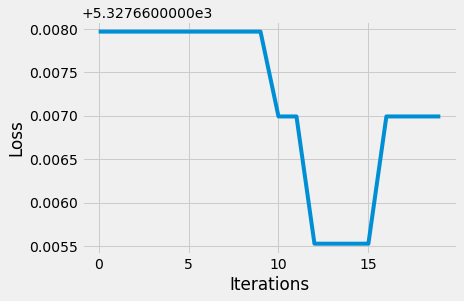

In [196]:
from tqdm import tqdm

epochs = 20
outputs = []
losses = []
data = torch.tensor(df_med.drop('id', axis=1).values).float()
for epoch in tqdm(range(epochs)):
       
      # Output of Autoencoder
    reconstructed = model(data)

    # Calculating the loss function
    loss = loss_function(reconstructed, data)

    # The gradients are set to zero,
    # the gradient is computed and stored.
    # .step() performs parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

      # Storing the losses in a list for plotting
    losses.append(loss.detach().numpy())
    outputs.append((epochs, data, reconstructed))
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses[-100:])

In [109]:
from sklearn.manifold import locally_linear_embedding

embed = locally_linear_embedding(df_med.drop('id', axis=1), n_neighbors=5, n_components=36)

In [113]:
train_score, test_score = fitiing_base_model(pd.concat([df_med['id'], pd.DataFrame(embed[0])], axis=1), df_target)

print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Среднее качество на треине 0.21870145915879696
Среднее качество на тесте 0.31495916943909763


In [114]:
embed = locally_linear_embedding(df_med.drop('id', axis=1), n_neighbors=5, n_components=500)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=64, random_state=0).fit(embed[0])

dists_columns = ['distanceto' + str(i) for i in range(64)]
dists_df = pd.DataFrame(
    data=kmeans.transform(embed[0]),
    columns=dists_columns
)
dists_df['cluster'] = kmeans.labels_


In [116]:
dists_df['id'] = df_med['id']
train_score, test_score = fitiing_base_model(dists_df, df_target)

print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Среднее качество на треине 0.24417522911077597
Среднее качество на тесте 0.33311748298444704


In [199]:
#Попытаемся поделить данные на кластеры и для каждого кластера будем использовать расстояние до них как фичи
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=32, random_state=0).fit(df_med.drop('id', axis=1).values)
df_cluster = df_med.copy()
df_cluster['cluster'] = kmeans.labels_

df_cluster['cluster'].value_counts()

17    2322
23    1821
0      965
10     944
8      486
9      404
4      184
31     173
2      139
14      98
3       58
13      56
25      53
27      45
6       38
22      32
24      32
7       29
11      22
28      16
1       15
30      14
12      12
19       8
26       8
20       7
21       5
18       4
5        4
16       2
15       2
29       2
Name: cluster, dtype: int64

In [200]:
dists_columns = ['distanceto' + str(i) for i in range(32)]
dists_df = pd.DataFrame(
    data=kmeans.transform(df_med.drop('id', axis=1).values),
    columns=dists_columns
)
dists_df['cluster'] = kmeans.labels_

In [201]:
dists_df.head()

,distanceto0,distanceto1,distanceto2,distanceto3,distanceto4,distanceto5,distanceto6,distanceto7,distanceto8,distanceto9,...,distanceto23,distanceto24,distanceto25,distanceto26,distanceto27,distanceto28,distanceto29,distanceto30,distanceto31,cluster
0,1158.757913,10308.004784,2184.890186,3570.769435,1764.062277,9178.431543,3627.118942,4014.283513,1053.936404,1398.246933,...,1064.633478,4828.255038,3091.622483,4353.631974,2134.944351,6097.128169,6706.759712,4070.352005,1730.354770,10
1,2328.430968,10536.283689,2936.952418,3616.225195,3165.649901,9412.048018,4153.316209,4485.342977,2356.793875,2367.509649,...,2231.856228,5248.819202,3661.109612,4771.867713,2457.018149,6414.249686,7131.921433,5081.690930,2676.794673,23
2,1354.269041,10152.716047,2277.135302,2934.142602,2554.509063,9108.994284,3612.459302,4105.696009,1405.134574,1446.620328,...,1208.402843,4808.928318,3373.489528,4334.749140,2218.127670,6038.226521,6798.884419,4849.692476,1934.536782,17
3,1406.865361,10370.923579,2341.821311,3205.296657,2411.399094,9139.948002,3745.038834,4135.639397,1348.906112,1640.540348,...,1423.353515,4910.366385,3192.496217,4460.675460,2286.118544,6151.521941,6824.796435,4715.060002,1961.524960,8
4,2991.281375,10717.269188,3417.343671,3931.443013,3767.556303,9515.787875,4533.260191,4862.391619,2734.903410,2951.016634,...,2822.275999,5552.325992,4071.903501,5003.978238,3379.531983,6641.413365,7179.568064,5248.549029,3222.049821,8


In [205]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


def svm_model(df, df_target):
    for col in df_target.drop('id', axis=1).columns:
        df_train, df_test = train_test_split(
            df,
            test_size=0.25
        )
        
        svm = SVC()
        svm_parameters_grid = {
            'C': [1, 0.5],
            'kernel': ['linear', 'sigmoid']
        }
        custom_cv = [(df_train.index.to_list(), df_test.index.to_list())]
        
        search_svm = GridSearchCV(
            svm,
            svm_parameters_grid,
            return_train_score=True
        )
        train = df_train.merge(df_target[['id', col]], on='id', how='inner')
        X, y = train.drop([col, 'id'], axis=1), train[col]
        
        search_svm.fit(X, y)
        svm = SVC(**search_svm.best_params_)
        svm.fit(X, y, verbose=False)
        
        scores_train.append(log_loss(y, svm.predict(X)))
        test = df_test.merge(df_target[['id', col]], on='id', how='inner')
        X, y = test.drop([col, 'id'], axis=1), test[col]
        scores_test.append(log_loss(y, svm.predict(X)))
    return (np.mean(scores_train), np.mean(scores_test))
    

In [ ]:
train_score, test_score = svm_model(df_med, df_target)

In [ ]:
print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


def gaussian_kernel(distances, h=1):
        return np.exp(- distances**2 / h**2)

    
def knn_model(df, df_target):
    for col in df_target.drop('id', axis=1).columns:
        df_train, df_test = train_test_split(
            df,
            test_size=0.25
        )
        parameters_grid = {
        'n_neighbors': [5, 10, 20],
        'weights': ['uniform', 'distance', gaussian_kernel],
        'p': (2, 1),
        }

        custom_cv = [(df_train.index.to_list(), df_test.index.to_list())]

        search_baseline = GridSearchCV(
            KNeighborsClassifier(),
            parameters_grid,
            scoring="accuracy",
            cv=custom_cv,
            verbose=10,
            return_train_score=True
        )
        
        train = df_train.merge(df_target[['id', col]], on='id', how='inner')
        X, y = train.drop([col, 'id'], axis=1), train[col]
        
        search_baseline.fit(X, y)
        knn = SVC(**search_baseline.best_params_)
        knn.fit(X, y, verbose=False)
        
        scores_train.append(log_loss(y, knn.predict(X)))
        test = df_test.merge(df_target[['id', col]], on='id', how='inner')
        X, y = test.drop([col, 'id'], axis=1), test[col]
        scores_test.append(log_loss(y, knn.predict(X)))
        

In [ ]:
train_score, test_score = knn_model(df_med, df_target)

print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

In [127]:
def fitiing_stack_model(df, df_target, cat_features=[]):
    model = CatBoostClassifier(iterations=50, cat_features=cat_features)
    df_train, df_test = train_test_split(
            df,
            test_size=0.25
        )
    for col in df_target.drop('id', axis=1).columns:
        train = df_train.merge(df_target[['id', col]], on='id', how='inner')
        X_train, y_train = train.drop([col, 'id'], axis=1), train[col]
        model.fit(X_train, y_train, verbose=False)
        scores_train.append(log_loss(y_train, model.predict_proba(X_train)[:, 1]))
        test = df_test.merge(df_target[['id', col]], on='id', how='inner')
        X_test, y_test = test.drop([col, 'id'], axis=1), test[col]
        scores_test.append(log_loss(y_test, model.predict_proba(X_test)[:, 1]))
        df_train[col] = model.predict_proba(X_train)[:, 1]
        df_test[col] = model.predict_proba(X_test)[:, 1]
    return (np.mean(scores_train), np.mean(scores_test))

In [128]:
train_score, test_score = fitiing_stack_model(df_med, df_target)

print('Среднее качество на треине', train_score)
print('Среднее качество на тесте', test_score)

Среднее качество на треине 0.2309097430994461
Среднее качество на тесте 0.3281247444918077
